In [29]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,8)

import statsmodels.formula.api as smf


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/df_train_mod.csv")
df.head()

,carat,cut,color,clarity,price
0,0.30,3,0,2,6.353
1,1.01,4,1,5,9.183
2,0.72,4,2,4,7.983
3,1.08,2,3,2,8.371
4,0.36,3,3,3,6.588


In [3]:
# dividimos el dataset en variables predictoras y respuesta
X = df.drop("price", axis = 1) # variables predictoras
y = df["price"] # variable respuesta 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 666)

In [5]:
y_train.describe()


count    32350.000000
mean         7.784970
std          1.016068
min          5.814000
25%          6.852000
50%          7.780000
75%          8.583000
max          9.842000
Name: price, dtype: float64

In [6]:
y_test.describe()

count    8088.000000
mean        7.776977
std         1.019094
min         5.787000
25%         6.842000
50%         7.776500
75%         8.565000
max         9.842000
Name: price, dtype: float64

# Regresión Lineal

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
# iniciamos el método de Linear Regression
lr = LinearRegression()

In [9]:
lr.fit(X_train, y_train)

LinearRegression()

In [10]:
lr.intercept_

6.03325842467235

In [11]:
lr.coef_

array([ 2.12579329,  0.02170659, -0.08037595,  0.06571428])

In [13]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

In [14]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_test,  'Set': ['Test']*len(y_test)})
results = pd.concat([train_df,test_df], axis = 0)
results.head()

,Real,Predicted,Set
15482,6.129,6.620741,Train
10304,7.432,7.159806,Train
5544,8.986,8.562381,Train
26966,8.950,8.623171,Train
6460,9.113,9.338121,Train


In [15]:
results['residual'] = results['Real'] - results['Predicted']
results.head()

,Real,Predicted,Set,residual
15482,6.129,6.620741,Train,-0.491741
10304,7.432,7.159806,Train,0.272194
5544,8.986,8.562381,Train,0.423619
26966,8.950,8.623171,Train,0.326829
6460,9.113,9.338121,Train,-0.225121


In [20]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("R2:",  metrics.r2_score(y_test, y_pred_test))

Mean Absolute Error: 0.2858825888420493
Mean Squared Error: 0.1321485366792584
Root Mean Squared Error: 0.36352240189465407
R2: 0.8727411608181033


In [21]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [22]:
lr_results = metricas(y_test, y_train, y_pred_test, y_pred_train, "Regresion lineal")


In [23]:
lr_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.285883,0.132149,0.363522,0.872741,test,Regresion lineal
1,0.284282,0.130680,0.361497,0.873416,train,Regresion lineal


# Decision Tree Classifier


In [30]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [31]:
# max features

max_features = np.sqrt(len(X_train.columns))
max_features

2.0

In [32]:
# max depth

print(regressor.tree_.max_depth)

24


In [33]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [34]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.088070,0.014095,0.118723,0.986426,test,Decission Tree I
1,0.053775,0.006104,0.078125,0.994088,train,Decission Tree I


In [66]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [3,4, 5, 6, 7,8,9,10],
        "min_samples_split": [10,25,50,75,100],
        "max_features": [1,2,3,4,5,6]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [67]:
%time
gs.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [10, 25, 50, 75, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
# sacamos cual es el mejor de todos los que hemos testeado usando el método best_estimator_

best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=10, max_features=6, min_samples_split=10)

In [69]:
y_pred_test_dt2 = best_tree.predict(X_test)
y_pred_train_dt2 = best_tree.predict(X_train)

In [71]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")


In [72]:
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.091007,0.013643,0.116805,0.986861,test,Decision tree II
1,0.084478,0.011923,0.109191,0.988451,train,Decision tree II


In [73]:
df_all = pd.concat([lr_results, dt_results2], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.285883,0.132149,0.363522,0.872741,test,Regresion lineal
1,0.284282,0.130680,0.361497,0.873416,train,Regresion lineal
0,0.091007,0.013643,0.116805,0.986861,test,Decision tree II
1,0.084478,0.011923,0.109191,0.988451,train,Decision tree II


In [50]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': regressor.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,carat,0.948507
1,cut,0.003104
2,color,0.015217
3,clarity,0.033172


In [54]:
importancia_predictores.sort_values(ascending=False, by= "importancia", inplace=True)
importancia_predictores

,predictor,importancia
0,carat,0.948507
3,clarity,0.033172
2,color,0.015217
1,cut,0.003104


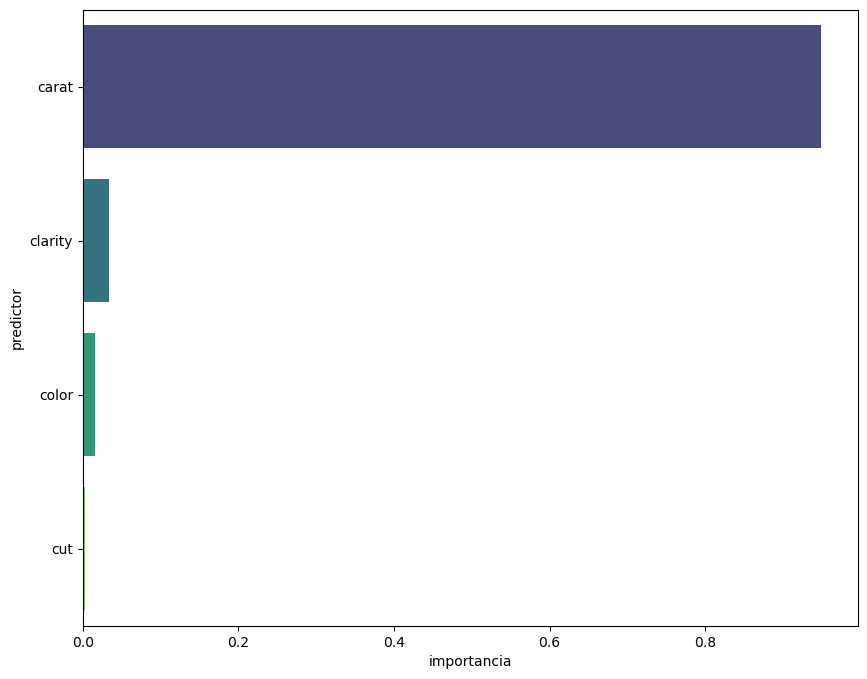

In [55]:
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");


# Random Forest


In [56]:
param = {"max_depth": [3,4, 5, 6, 7,8,9,10],
        "min_samples_split": [10,25,50,75,100],
        "max_features": [1,2,3,4,5,6]}

bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [57]:
%time
bosque.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [10, 25, 50, 75, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
bos = bosque.best_estimator_
bos

RandomForestRegressor(max_depth=10, max_features=3, min_samples_split=10)

In [59]:
# prediccion 
y_pred_test_rf = bos.predict(X_test)
y_pred_train_rf = bos.predict(X_train)

In [61]:
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.083934,0.011549,0.107467,0.988878,test,Random Forest
1,0.078789,0.010377,0.101868,0.989948,train,Random Forest


In [74]:
df_all = pd.concat([df_all, rf_results ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.285883,0.132149,0.363522,0.872741,test,Regresion lineal
1,0.284282,0.130680,0.361497,0.873416,train,Regresion lineal
0,0.091007,0.013643,0.116805,0.986861,test,Decision tree II
1,0.084478,0.011923,0.109191,0.988451,train,Decision tree II
0,0.083934,0.011549,0.107467,0.988878,test,Random Forest
1,0.078789,0.010377,0.101868,0.989948,train,Random Forest


In [64]:
importancia_predictores_rf = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': bos.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_rf

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,carat,0.947643
1,cut,0.002498
2,color,0.015123
3,clarity,0.034736


In [65]:
importancia_predictores_rf.sort_values(ascending=False, by= "importancia", inplace=True)
importancia_predictores_rf

,predictor,importancia
0,carat,0.947643
3,clarity,0.034736
2,color,0.015123
1,cut,0.002498


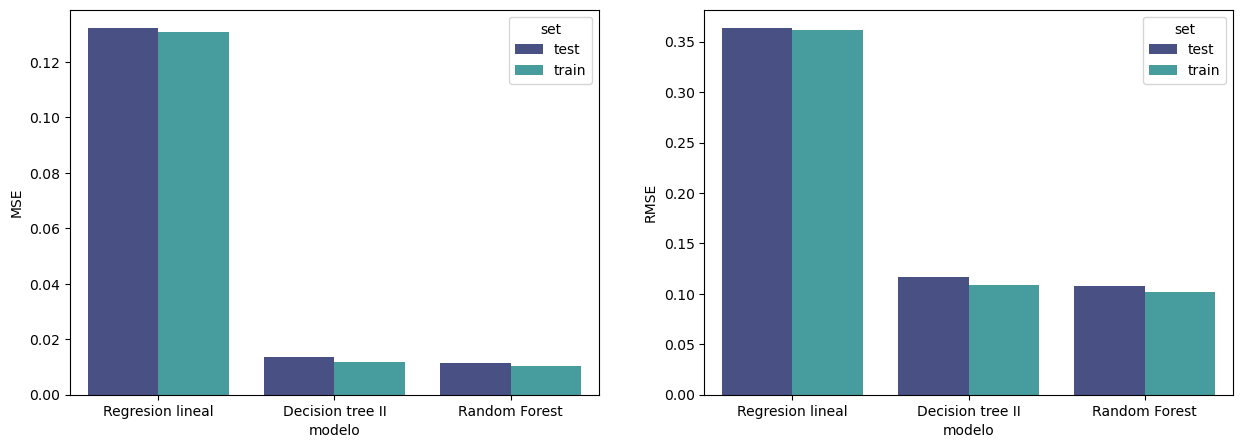

In [76]:
fig, axes = plt.subplots(1,2, figsize =(15,5))

sns.barplot(data = df_all, x = "modelo", y = "MSE", hue = "set", ax = axes[0], palette="mako")
sns.barplot(data = df_all, x = "modelo", y = "RMSE", hue = "set",ax = axes[1], palette = "mako");

- En los resultados de evaluación proporcionados, el modelo con el mejor MSE es el modelo de Random Forest, con un valor de MSE de 0.010377 en el conjunto de entrenamiento y 0.011549 en el conjunto de prueba. Esto significa que este modelo tiene el menor error cuadrático medio entre las predicciones y los valores reales en comparación con los otros modelos evaluados.

In [88]:
import pickle

In [91]:
# guardamos el mejor modelo
with open("../data/mejor_modelo.pkl", "wb") as modelo:
        pickle.dump(bosque, modelo)